In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install opustools-pkg
!pip install sacremoses
!pip install swifter
## clone indic nlp resources repo
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
## install indic nlp library
!pip install indic-nlp-library

     |████████████████████████████████| 80 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 12.1 MB/s 
     |████████████████████████████████| 296 kB 13.5 MB/s 
     |████████████████████████████████| 119 kB 61.0 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (53/53), done.
     |████████████████████████████████| 40 kB 51 kB/s 
     |████████████████████████████████| 9.1 MB 18.2 MB/s 
     |████████████████████████████████| 548 kB 56.5 MB/s 
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os
import re
import string
import swifter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from unicodedata import normalize
import time
from sklearn.model_selection import train_test_split
from sacremoses import MosesTokenizer
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

In [ ]:
# source and target languages
src_lang = "en"
tgt_lang = "hi"

# data directory where train, test and validation datasets are present
data_dir = "/content/drive/MyDrive/domain_adaptation/data/updated_data/"

# input tsv file
input_tsv_file = os.path.join(data_dir, "pmindia.v1.hi-en.tsv")

# train files
tr_src = os.path.join(data_dir, "train.en")
tr_tgt = os.path.join(data_dir, "train.hi")

# domain files
health_src = os.path.join(data_dir, "health_data.en")
health_tgt = os.path.join(data_dir, "health_data.hi")

## domain nhs files
health_nhs_src = os.path.join(data_dir, "nhs_inform_extra.en")
health_nhs_tgt = os.path.join(data_dir, "nhs_inform_extra.hi")

# test files
test_src = os.path.join(data_dir, "nhs_inform.en")
test_tgt = os.path.join(data_dir, "nhs_inform.hi")

## export indic nlp resource library
os.environ["INDIC_RESOURCES_PATH"] = "/content/indic_nlp_resources"

In [ ]:
## setting up environmental variables

os.environ['src_lang'] = src_lang
os.environ['tgt_lant'] = tgt_lang

os.environ['tr_src'] = tr_src
os.environ['tr_tgt'] = tr_tgt

os.environ['health_src'] = health_src
os.environ['health_tgt'] = health_tgt

os.environ['health_nhs_src'] = health_nhs_src
os.environ['health_nhs_tgt'] = health_nhs_tgt

os.environ['test_src'] = test_src
os.environ['test_tgt'] = test_tgt

In [ ]:
## reading data from "input_tsv_file" i.e pm india hi-en parallel corpus

df_train_raw = pd.read_csv(input_tsv_file, sep = '\t',  header = None, names = ['src_sentence', 'tgt_sentence'])

In [ ]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56831 entries, 0 to 56830
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   src_sentence  56831 non-null  object
 1   tgt_sentence  56831 non-null  object
dtypes: object(2)
memory usage: 888.1+ KB


In [ ]:
import re

def check_for_eng(input_text):
  english_words =  re.findall(r"[a-zA-z]+", input_text)
  return len(english_words)


print(check_for_eng('और इसलिये memory recall करने की सबसे बड़ी अगर कोई औषधि है, तो वो relaxation है।'))

In [ ]:
df_train_raw['tgt_eng_word_count'] = df_train_raw['tgt_sentence'].swifter.apply(check_for_eng)

Pandas Apply:   0%|          | 0/56831 [00:00<?, ?it/s]

In [ ]:
df_train = df_train_raw[df_train_raw['tgt_eng_word_count'] == 0]
df_train = df_train[['src_sentence', 'tgt_sentence']]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53876 entries, 0 to 56830
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   src_sentence  53876 non-null  object
 1   tgt_sentence  53876 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
!wc -l $health_src $health_tgt $health_nhs_src $health_nhs_tgt $test_src $test_tgt

   5464 /content/drive/MyDrive/domain_adaptation/data/updated_data/health_data.en
   5464 /content/drive/MyDrive/domain_adaptation/data/updated_data/health_data.hi
   1355 /content/drive/MyDrive/domain_adaptation/data/updated_data/nhs_inform_extra.en
   1355 /content/drive/MyDrive/domain_adaptation/data/updated_data/nhs_inform_extra.hi
    598 /content/drive/MyDrive/domain_adaptation/data/updated_data/nhs_inform.en
    598 /content/drive/MyDrive/domain_adaptation/data/updated_data/nhs_inform.hi
  14834 total


In [ ]:
def create_df(src_file, tgt_file):
  src = []
  tgt = []

  with open(src_file, 'r') as src_, open(tgt_file, 'r') as tgt_:
    src_lines = src_.readlines()
    tgt_lines = tgt_.readlines()

  for line_index in range(len(src_lines)):
    src.append(src_lines[line_index].strip('\n'))
    tgt.append(tgt_lines[line_index].strip('\n'))

  df = pd.DataFrame({'src_sentence': src,
                     'tgt_sentence': tgt})

  return df

In [ ]:
df_test = create_df(test_src, test_tgt)
df_health = create_df(health_src, health_tgt)
df_nhs = create_df(health_nhs_src, health_nhs_tgt)

In [ ]:
df_nhs_pp = df_nhs.drop_duplicates()
df_nhs_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 0 to 1353
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   src_sentence  1282 non-null   object
 1   tgt_sentence  1282 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


In [ ]:
df_nhs_pp.drop_duplicates(subset='src_sentence', inplace=True)
df_nhs_pp.drop_duplicates(subset='tgt_sentence', inplace=True)
df_nhs_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 0 to 1353
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   src_sentence  1151 non-null   object
 1   tgt_sentence  1151 non-null   object
dtypes: object(2)
memory usage: 27.0+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_nhs_pp.head()

,src_sentence,tgt_sentence
0,Coronavirus (COVID-19): Shielding,कोरोनावायरस (कोविड-19) : परिरक्षण
1,People on the shielding list should strictly f...,परिरक्षण सूची के लोगों को शारीरिक रूप से दूरी ...
2,Read the Scottish Government's Coronavirus (CO...,स्कॉटिश सरकार के कोरोनावायरस (कोविड-19) को पढ़...
3,If you were previously told to shield,अगर आपको पहले परिरक्षण के लिए कहा गया था
4,"Before the virus, clinicians advised some peop...","वायरस से पहले, चिकित्सकों ने कुछ लोगों को कुछ ..."


In [ ]:
## punctuations except single quotes, double quotes, comma, full stop, hypen and colon
punc = string.punctuation
punc = punc.replace(".", "")
punc = punc.replace(",", "")
punc = punc.replace("'", "")
punc = punc.replace('"', "")
punc = punc.replace("-", "")
punc = punc.replace(":", "")
## unwated punctuation chars
exclude = set(punc)

## function to replace devanagari numbers with english numbers
def replace_hi_en_num(input_text):
  hi_en_num_map = {"०":"0", "१":"1", "२":"2", "३":"3", "४": "4", "५":"5", "६":"6", "७":"7", "८":"8", "९":"9"}
  estring = ""
  for char in input_text:
    if char in hi_en_num_map:
      estring = estring + hi_en_num_map[char]
    else:
      estring = estring + char
  return estring


## function to replace unfinished quote e.g. he said, "tomorrow is sunny day. -> he said, tomorrow is sunny day
def replace_unfinished_quotes(input_text):
  if input_text.count('"') == 1:
    input_text = input_text.replace('"', "")
  return input_text

## function to clean english sentences
def clean_en(input_text):
  ## remove text between braces, either () or []
  input_text = re.sub("\[.*?\]","", input_text)
  input_text = re.sub("\(.*?\)","", input_text)

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  ## remove extra spaces
  input_text = input_text.strip()
  input_text = re.sub(" +", " ", input_text)
  ## remove space between full stop
  input_text = input_text.replace(" .", ".")

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  ## remove unfinished quotes
  input_text = replace_unfinished_quotes(input_text)

  ## remove space before hypen if exists
  input_text = input_text.replace(" -", "-")

  ## return clean text
  return " ".join(input_text.split())

## function to clean hindi sentences  
def clean_hi(input_text):
  ## remove text between braces, either () or [] and &;
  input_text = re.sub("\[.*?\]","", input_text)
  input_text = re.sub("\(.*?\)","", input_text)

  ## Normalizing text
  factory = IndicNormalizerFactory()
  normalizer = factory.get_normalizer("hi", remove_nuktas = False)
  input_text = normalizer.normalize(input_text)

  ## convert hindi numbers to english
  input_text_tokens = input_text.split()
  input_text = [replace_hi_en_num(word) for word in input_text_tokens]
  input_text = " ".join(input_text)

  ## remove unwated punctuations
  input_text = ''.join(ch for ch in input_text if ch not in exclude)

  ## remove unfinished quotes
  input_text = replace_unfinished_quotes(input_text)

  ## remove space before hypen if exists
  input_text = input_text.replace(" -", "-")

  ## remove extra spaces
  input_text = input_text.strip()
  input_text = re.sub(" +", " ", input_text)

  ## return clean text
  return " ".join(input_text.split())

In [ ]:
## cleaning train, dev and test data
## train
df_train['clean_src_sentence'] = df_train['src_sentence'].swifter.apply(clean_en)
df_train['clean_tgt_sentence'] = df_train['tgt_sentence'].swifter.apply(clean_hi)

## health
df_health['clean_src_sentence'] = df_health['src_sentence'].swifter.apply(clean_en)
df_health['clean_tgt_sentence'] = df_health['tgt_sentence'].swifter.apply(clean_hi)

##nhs_inform
df_nhs_pp['clean_src_sentence'] = df_nhs_pp['src_sentence'].swifter.apply(clean_en)
df_nhs_pp['clean_tgt_sentence'] = df_nhs_pp['tgt_sentence'].swifter.apply(clean_hi)

## test
df_test['clean_src_sentence'] = df_test['src_sentence'].swifter.apply(clean_en)
df_test['clean_tgt_sentence'] = df_test['tgt_sentence'].swifter.apply(clean_hi)

Pandas Apply:   0%|          | 0/53876 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53876 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Pandas Apply:   0%|          | 0/1151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

In [ ]:
### splitting data 500 rows from train data for validation purpose

df_train, df_dev = train_test_split(df_train, test_size=0.0093, random_state=42, shuffle=True)

df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 1948 to 33488
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   src_sentence        502 non-null    object
 1   tgt_sentence        502 non-null    object
 2   clean_src_sentence  502 non-null    object
 3   clean_tgt_sentence  502 non-null    object
dtypes: object(4)
memory usage: 19.6+ KB


In [ ]:
df_train['len_src_sentence'] = df_train['clean_src_sentence'].swifter.apply(lambda x: len(x.split(' ')))
df_train['len_tgt_sentence'] = df_train['clean_tgt_sentence'].swifter.apply(lambda x: len(x.split(' ')))

df_dev['len_src_sentence'] = df_dev['clean_src_sentence'].swifter.apply(lambda x: len(x.split(' ')))
df_dev['len_tgt_sentence'] = df_dev['clean_tgt_sentence'].swifter.apply(lambda x: len(x.split(' ')))

df_health['len_src_sentence'] = df_health['clean_src_sentence'].swifter.apply(lambda x: len(x.split(' ')))
df_health['len_tgt_sentence'] = df_health['clean_tgt_sentence'].swifter.apply(lambda x: len(x.split(' ')))

df_nhs_pp['len_src_sentence'] = df_nhs_pp['clean_src_sentence'].swifter.apply(lambda x: len(x.split(' ')))
df_nhs_pp['len_tgt_sentence'] = df_nhs_pp['clean_tgt_sentence'].swifter.apply(lambda x: len(x.split(' ')))

df_test['len_src_sentence'] = df_test['clean_src_sentence'].swifter.apply(lambda x: len(x.split(' ')))
df_test['len_tgt_sentence'] = df_test['clean_tgt_sentence'].swifter.apply(lambda x: len(x.split(' ')))

Pandas Apply:   0%|          | 0/53374 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53374 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/502 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/502 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Pandas Apply:   0%|          | 0/1151 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

In [ ]:
def show_max_mean_lengths(input_df, dataset_name):
  print("Max sentence length in {} EN: {}".format(dataset_name, max(input_df['len_src_sentence'])))
  print("Max sentence length in {} HI: {}".format(dataset_name, max(input_df['len_tgt_sentence'])))
  print()
  print("Average sentence length in {} EN: {}".format(dataset_name, round(np.mean(input_df['len_src_sentence']))))
  print("Average sentence length in {} HI: {}".format(dataset_name, round(np.mean(input_df['len_tgt_sentence']))))
  print()


show_max_mean_lengths(df_train, "Train")
show_max_mean_lengths(df_dev, "Dev")
show_max_mean_lengths(df_test, "Test")
show_max_mean_lengths(df_health, "Health")
show_max_mean_lengths(df_nhs_pp, "NHS Inform")

Max sentence length in Train EN: 141
Max sentence length in Train HI: 208

Average sentence length in Train EN: 19
Average sentence length in Train HI: 20

Max sentence length in Dev EN: 71
Max sentence length in Dev HI: 74

Average sentence length in Dev EN: 18
Average sentence length in Dev HI: 20

Max sentence length in Test EN: 45
Max sentence length in Test HI: 61

Average sentence length in Test EN: 12
Average sentence length in Test HI: 14

Max sentence length in Health EN: 81
Max sentence length in Health HI: 89

Average sentence length in Health EN: 18
Average sentence length in Health HI: 21

Max sentence length in NHS Inform EN: 39
Max sentence length in NHS Inform HI: 55

Average sentence length in NHS Inform EN: 13
Average sentence length in NHS Inform HI: 16



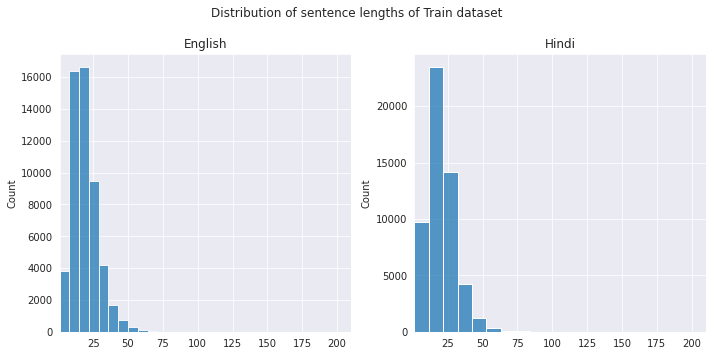

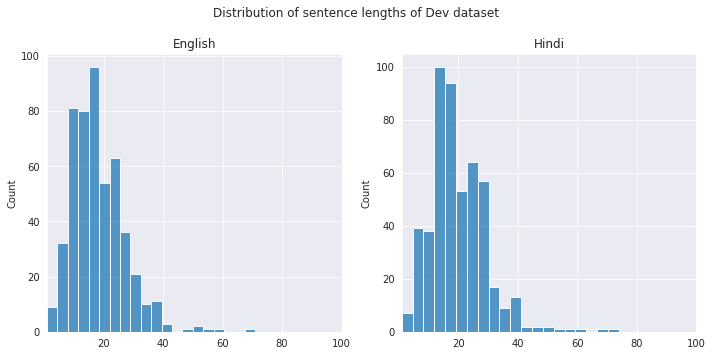

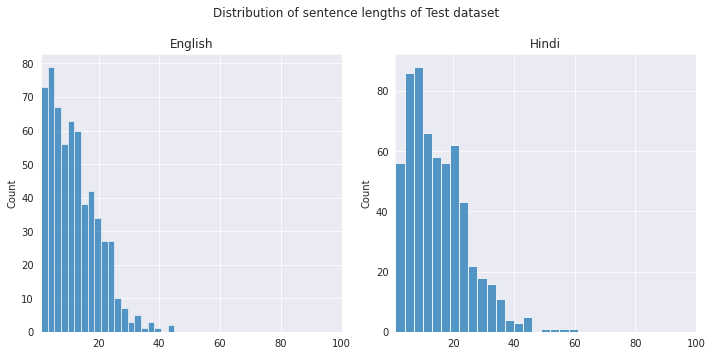

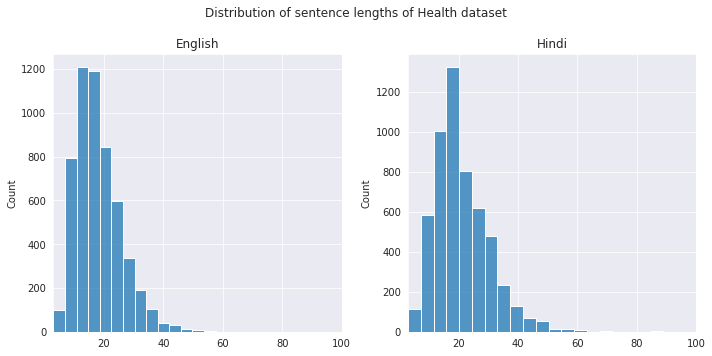

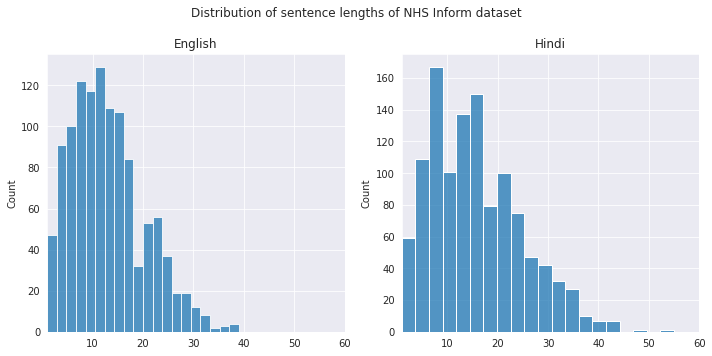

In [ ]:
def plot_histogram(input_df, ds_name, x_max_limit):

  title = "Distribution of sentence lengths of " + ds_name + " dataset"
  fig = plt.figure(figsize=(10,5))

  sns.set_style("darkgrid")

  ax1 = fig.add_subplot(1,2,1)
  ax1.set_xlim([min(input_df["len_src_sentence"]), x_max_limit])
  ax1 = sns.histplot(data = input_df, x = "len_src_sentence", bins = 20)
  ax1.set(xlabel = None)
  ax1.set_title("English")

  ax2 = fig.add_subplot(1,2,2)
  ax2.set_xlim([min(input_df["len_tgt_sentence"]), x_max_limit])
  ax2 = sns.histplot(data = input_df, x = "len_tgt_sentence", bins = 20)
  ax2.set(xlabel = None)
  ax2.set_title("Hindi")

  plt.tight_layout()
  plt.suptitle(title)
  plt.subplots_adjust(top=0.85)
  plt.show()


## histograms of lengths of sentences (source and target) for train, dev and test datasets
## Train
plot_histogram(df_train, "Train", 210)
print()
## Dev
plot_histogram(df_dev, "Dev", 100)
print()
## Test
plot_histogram(df_test, "Test", 100)
## Health
plot_histogram(df_health, "Health", 100)
## NHS Inform
plot_histogram(df_nhs_pp, "NHS Inform", 60)

In [ ]:
df_test["clean_src_sentence"][:5].to_list()

['Corona virus is the illness caused by a new strain of corona virus first identified in Wuhan city, China.',
 'It can cause a new continuous cough, fever or loss of, or change in, sense of smell or taste.',
 'Generally, corona virus can cause more severe symptoms in people with weakened immune systems, older people and those with long term conditions like diabetes, cancer and chronic lung disease.',
 'This is a rapidly changing situation which is being monitored carefully.',
 'What you can and cannot do depends on your protection level.']

In [ ]:
df_test["clean_tgt_sentence"][:5].to_list()

['कोरोनावायरस , वुहान शहर, चीन में पहली बार पहचाने गए कोरोनावायरस के एक नए तनाव के कारण होने वाली बीमारी है।',
 'यह एक नई तरह की और निरंतर खांसी, बुखार या गंध अथवा स्वाद में बदलाव या कमी का कारण बन सकता है।',
 'आमतौर पर, कोरोनावायरस कमजोर प्रतिरक्षा प्रणाली वाले लोगों, वृद्ध लोगों और मधुमेह, कैंसर और दीर्घकालिक फेफड़ों की बीमारी जैसी स्थितियों वाले लोगों में अधिक गंभीर लक्षण पैदा कर सकता है।',
 'यह तेजी से बदलती हुई स्थिति है जिस पर सावधानी से नजर रखी जा रही है।',
 'आप क्या कर सकते हैं और क्या नहीं यह आपके सुरक्षा स्तर पर निर्भर करता है।']

In [ ]:
df_health["clean_src_sentence"][:5].to_list()

['A paragraph from the author book on cancer, published in 1973, deserves repetition here.',
 'Doing nothing neither diagnosing nor treating unless compelled by a cancerous patient disease is the highest form of non empiricism, non arbitrarism, a kind of merespectyou andNature creed.',
 'It is refusing to interfere backing the refusal by a well deserved assurance or discreet resignation.',
 'Agreed that there is never nothing to be done, but this "never nothing" should be, whenever warranted, a Jeffersonian "pious" fraud.',
 'It cannot be overemphasized that a doctor is an adviser first and foremost, a doer only when the situation dictates.']

In [ ]:
df_health["clean_tgt_sentence"][:5].to_list()

['कैन्सर के बारे में लेखक की एक पुस्तक, जो 1973 में प्रकाशित हुई, से एक अनुच्छेद यहाँ दुहराए जाने योग्य है।',
 'कुछ भी न करना जब तक कैन्सर के मरीज के मर्ज़ से बाध्य न हो जाएँ तब तक न निदान करना और न उपचार- यह अननुभूतचिकित्सा, स्वेच्छाचारिता, एक प्रकार के मेरा आदर करो तुम तथा प्रकृति में विश्वास की पराकाष्ठा का रूप है।',
 'यह अस्वीकृति को एक सुयोग्य आश्वासन या सोच-समझ भरी परित्याग-भावना का सहारा देकर हस्तक्षेप करने से मना करना है।',
 'माना कि कभी भी कुछ न करने की नौबत नहीं आती, परन्तु जब कभी जरूरी हो, यह "कभी कुछ नहीं" जेफर्सन का "पवित्र" छल होना चाहिए।',
 'इस पर अधिक ज़ोर देने की आवश्यकता हो ही नहीं सकती कि कोई भी चिकित्सक पहले एक सलाहकार होता है, कर्ता सिर्फ तभी जब परिस्थिति बाध्य करे।']

In [ ]:
df_nhs_pp["clean_src_sentence"][:5].to_list()

['Coronavirus : Shielding',
 'People on the shielding list should strictly follow physical distancing and hygiene measures.',
 "Read the Scottish Government's Coronavirus : shielding advice and support",
 'If you were previously told to shield',
 'Before the virus, clinicians advised some people to avoid doing certain things.']

In [ ]:
df_nhs_pp["clean_tgt_sentence"][:5].to_list()

['कोरोनावायरस : परिरक्षण',
 'परिरक्षण सूची के लोगों को शारीरिक रूप से दूरी और स्वच्छता के उपायों का सख्ती से पालन करना चाहिए।',
 'स्कॉटिश सरकार के कोरोनावायरस को पढ़ें : परिरक्षण पर सलाह और सहायता',
 'अगर आपको पहले परिरक्षण के लिए कहा गया था',
 'वायरस से पहले, चिकित्सकों ने कुछ लोगों को कुछ चीजें करने से बचने की सलाह दी थी।']

In [ ]:
## concatinate health domain and nhs_inform data

df_health_concat = pd.concat([df_health, df_nhs_pp], ignore_index=True)
df_health_concat = df_health_concat.sample(frac = 1)
df_health_concat.tail(10)

,src_sentence,tgt_sentence,clean_src_sentence,clean_tgt_sentence,len_src_sentence,len_tgt_sentence,clean_src_sentence_tokenized,clean_tgt_sentence_tokenized
6014,want to have someone else with you during the ...,अपॉइंटमेंट के दौरान अपने साथ किसी और को ले जान...,want to have someone else with you during the ...,अपॉइंटमेंट के दौरान अपने साथ किसी और को ले जान...,10,11,want to have someone else with you during the ...,अपॉइंटमेंट के दौरान अपने साथ किसी और को ले जान...
4524,Weight forage reflects both chronic and acute ...,"इसके अलावा, सोडियम भ्रूण के लिए हानिकारक हो सक...",Weight forage reflects both chronic and acute ...,"इसके अलावा, सोडियम भ्रूण के लिए हानिकारक हो सक...",8,10,Weight forage reflects both chronic and acute ...,"इसके अलावा , सोडियम भ्रूण के लिए हानिकारक हो स..."
3877,ORS solution never causes pulmonary oedema.,ओआरएस घोल कभीभी फुफ्फुसीय सूजन उत्पन्न नहीं कर...,ORS solution never causes pulmonary oedema.,ओआरएस घोल कभीभी फुफ्फुसीय सूजन उत्पन्न नहीं कर...,6,9,ORS solution never causes pulmonary oedema .,ओआरएस घोल कभीभी फुफ्फुसीय सूजन उत्पन्न नहीं कर...
4517,"Between April 1992 and September 1993, the FHS...","हालांकि, सभी गर्भवती महिलाओं के लिए पत्ते की ख...","Between April 1992 and September 1993, the FHS...","हालांकि, सभी गर्भवती महिलाओं के लिए पत्ते की ख...",27,16,"Between April 1992 and September 1993 , the FH...","हालांकि , सभी गर्भवती महिलाओं के लिए पत्ते की ..."
3161,"These conditions are serious but manageable, s...","ये रोग गंभीर किन्तु नियंत्रणीय हैं, इसलिए अपने...","These conditions are serious but manageable, s...","ये रोग गंभीर किन्तु नियंत्रणीय हैं, इसलिए अपने...",22,28,"These conditions are serious but manageable , ...","ये रोग गंभीर किन्तु नियंत्रणीय हैं , इसलिए अपन..."
4541,"Even in Kerala, which has the lowest infant an...","यद्यपि अतिरिक्त पोषक तत्वों कि आवश्यकता हैं, प...","Even in Kerala, which has the lowest infant an...","यद्यपि अतिरिक्त पोषक तत्वों कि आवश्यकता हैं, प...",27,17,"Even in Kerala , which has the lowest infant a...","यद्यपि अतिरिक्त पोषक तत्वों कि आवश्यकता हैं , ..."
2979,The US Food and Drug Administration estimates ...,यूएस फूड एंड ड्रग एडमिनिस्ट्रेशन आकलन करता है ...,The US Food and Drug Administration estimates ...,यूएस फूड एंड ड्रग एडमिनिस्ट्रेशन आकलन करता है ...,39,45,The US Food and Drug Administration estimates ...,यूएस फूड एंड ड्रग एडमिनिस्ट्रेशन आकलन करता है ...
3824,Commercial pellet diet is used which is supple...,विशेषतः गिनी पिगों और खरगोशों के लिए वाणिज्यिक...,Commercial pellet diet is used which is supple...,विशेषतः गिनी पिगों और खरगोशों के लिए वाणिज्यिक...,24,28,Commercial pellet diet is used which is supple...,विशेषतः गिनी पिगों और खरगोशों के लिए वाणिज्यिक...
428,The skin around the nostrils may become sore.,नासारंध्रों के पास की त्वचा सूज सकती है।,The skin around the nostrils may become sore.,नासारंध्रों के पास की त्वचा सूज सकती है।,8,8,The skin around the nostrils may become sore .,नासारंध्रों के पास की त्वचा सूज सकती है ।
530,The only effective treatment for dyspepsia is ...,अजीर्ण का एकमात्र प्रभावी उपचार पाचन क्षेत्र क...,The only effective treatment for dyspepsia is ...,अजीर्ण का एकमात्र प्रभावी उपचार पाचन क्षेत्र क...,28,24,The only effective treatment for dyspepsia is ...,अजीर्ण का एकमात्र प्रभावी उपचार पाचन क्षेत्र क...


In [ ]:
def tokenize_en(input_text):
  mt = MosesTokenizer(lang='en')
  return mt.tokenize(input_text, return_str=True)

def tokenize_hi(input_text):
  return " ".join(indic_tokenize.trivial_tokenize(input_text))

In [ ]:
## tokenize train dataset
df_train['clean_src_sentence_tokenized'] = df_train['clean_src_sentence'].swifter.apply(tokenize_en)
df_train['clean_tgt_sentence_tokenized'] = df_train['clean_tgt_sentence'].swifter.apply(tokenize_hi)

## tokenize dev dataset
df_dev['clean_src_sentence_tokenized'] = df_dev['clean_src_sentence'].swifter.apply(tokenize_en)
df_dev['clean_tgt_sentence_tokenized'] = df_dev['clean_tgt_sentence'].swifter.apply(tokenize_hi)

## tokenize health dataset
df_health['clean_src_sentence_tokenized'] = df_health['clean_src_sentence'].swifter.apply(tokenize_en)
df_health['clean_tgt_sentence_tokenized'] = df_health['clean_tgt_sentence'].swifter.apply(tokenize_hi)

## tokenize health concat dataset
df_health_concat['clean_src_sentence_tokenized'] = df_health_concat['clean_src_sentence'].swifter.apply(tokenize_en)
df_health_concat['clean_tgt_sentence_tokenized'] = df_health_concat['clean_tgt_sentence'].swifter.apply(tokenize_hi)

## tokenize test dataset
df_test['clean_src_sentence_tokenized'] = df_test['clean_src_sentence'].swifter.apply(tokenize_en)
df_test['clean_tgt_sentence_tokenized'] = df_test['clean_tgt_sentence'].swifter.apply(tokenize_hi)

Pandas Apply:   0%|          | 0/53374 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/53374 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/502 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/502 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5464 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6615 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6615 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598 [00:00<?, ?it/s]

In [ ]:
def create_tok_files(input_df, dataset_name):
  src_tok_file = dataset_name + "_tok.en"
  tgt_tok_file = dataset_name + "_tok.hi"
  src_content = input_df['clean_src_sentence_tokenized'].to_list()
  tgt_content = input_df['clean_tgt_sentence_tokenized'].to_list()

  with open(src_tok_file, 'w') as src, open(tgt_tok_file, 'w') as tgt:
    for src_line, tgt_line in zip(src_content, tgt_content):
      src.write(src_line + "\n")
      tgt.write(tgt_line + "\n")


In [ ]:
create_tok_files(df_train, "train")
create_tok_files(df_dev, "dev")
create_tok_files(df_test, "test")
create_tok_files(df_health, "health")
create_tok_files(df_health_concat, "health_concat")

In [ ]:
en_test_sents = set()
filter_test_sents = "test_tok.en"
j = 0
with open(filter_test_sents) as f:
  for line in f:
    en_test_sents.add(line.strip())
    j += 1
print('Loaded {} global test sentences to filter from the test data.'.format(j))

Loaded 598 global test sentences to filter from the test data.


In [ ]:
source = []
target = []
skip_lines = []  # Collect the line numbers of the source portion to skip the same lines for the target portion.
with open('health_concat_tok.en') as f:
    for i, line in enumerate(f):
        # Skip sentences that are contained in the test set.
        if line.strip() not in en_test_sents:
            source.append(line.strip())
        else:
            skip_lines.append(i)             
with open('health_concat_tok.hi') as f:
    for j, line in enumerate(f):
        # Only add to corpus if corresponding source was not skipped.
        if j not in skip_lines:
            target.append(line.strip())
    
print('Loaded test data and skipping {}/{} lines from train dataset since it overlaps with lines in test set.'.format(len(skip_lines), i))

df_health_concat_filtered = pd.DataFrame(zip(source, target), columns=['src_sentence', 'tgt_sentence'])

Loaded test data and skipping 33/6614 lines from train dataset since it overlaps with lines in test set.


In [ ]:
df_health_concat_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   src_sentence  6582 non-null   object
 1   tgt_sentence  6582 non-null   object
dtypes: object(2)
memory usage: 103.0+ KB


In [ ]:
enlines = df_health_concat_filtered['src_sentence'].to_list()
hilines = df_health_concat_filtered['tgt_sentence'].to_list()

with open('health_concat_filtered_tok.en', 'w') as entok, open('health_concat_filtered_tok.hi', 'w') as hitok:
  for enline, hiline in zip(enlines, hilines):
    entok.write(enline.strip() + "\n")
    hitok.write(hiline.strip() + "\n")

In [ ]:
os.environ["gdrive_datadir"] = "/content/drive/MyDrive/DA/updated_data_tok_files"
!mkdir -p $gdrive_datadir
!cp *_tok* $gdrive_datadir

In [ ]:
!head -10 train_tok* dev_tok* test_tok* health_concat_filtered_tok*

==> train_tok.en <==
He underlined his commitment to deepen India-France defence and security cooperation and looked forward to receiving Prime Minister in France this year .
Our campaign against tax evasion and money laundering is also well known .
Some Government officers have also committed serious offences , and tried to take advantage of the situation .
The Union Cabinet chaired by Prime Minister Shri Narendra Modi has given its ex-post facto approval for entering into Headquarters Agreement between India and the International Solar Alliance and authorizing the Ministry of External Affairs for signing the Headquarter Agreement .
The Prime Minister said that the decades old Land Boundary issue between India and Bangladesh had been successfully resolved through the same spirit of Team India , as all state governments and political parties had come together to support the resolution of the issue .
It has been forged by our intersecting history our centuries-old ties of kinship , comm